**Importing Dependences**

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from collections import Counter

# **Loading Dataset**

In [4]:
DATASET_DIR = '/kaggle/input/trashnet/dataset'

In [5]:
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Resizing images to 224x224 for MobileNetV2
BATCH_SIZE = 32
INITIAL_EPOCHS = 50    # Initial training epochs
FINE_TUNE_EPOCHS = 20  # Fine-tuning epochs
NUM_CLASSES = 6 

# **Enhanced Data Augmentation for training**

In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 20% for validation
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# **Create generators**

In [8]:

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

Found 2024 images belonging to 6 classes.


In [9]:
validation_generator = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

Found 503 images belonging to 6 classes.


# **Function to generate class weights**

In [10]:
def compute_class_weights(generator):
    counter = Counter(generator.classes)
    max_count = float(max(counter.values()))
    class_weights = {cls: max_count / count for cls, count in counter.items()}
    return class_weights
    
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

class_weights = compute_class_weights(train_generator)
print("Class weights:", class_weights)

Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class weights: {0: 1.4736842105263157, 1: 1.1870324189526185, 2: 1.451219512195122, 3: 1.0, 4: 1.233160621761658, 5: 4.327272727272727}


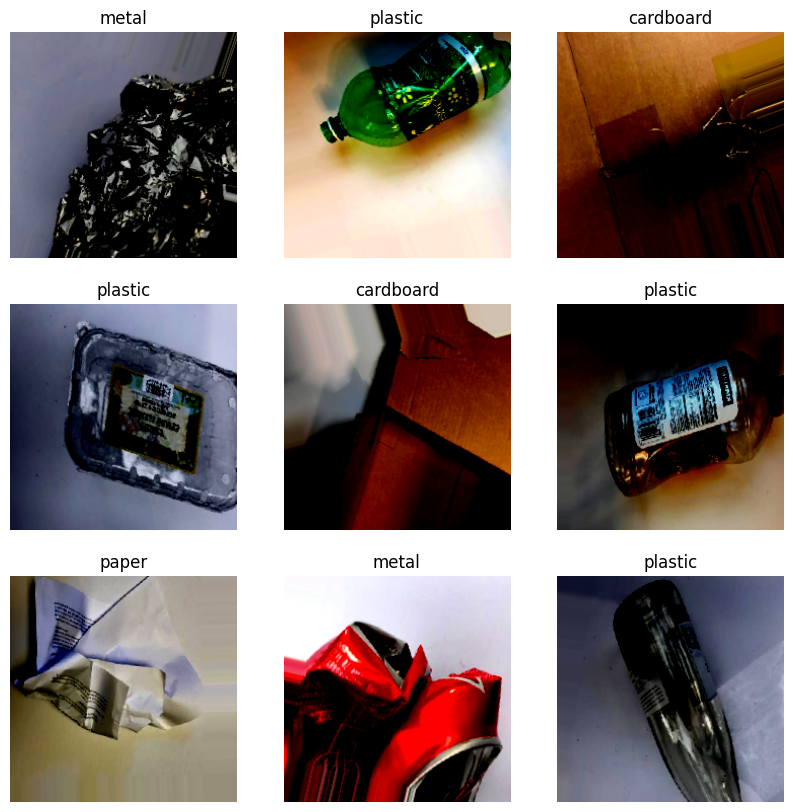

In [11]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis('off')
plt.show()

# **Build the model using MobileNetV2 as the base**

In [50]:
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
base_model.trainable = False  # Freeze the base model initially

<ipython-input-50-b477b5650253>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False,


# **Adding custom layers**

In [51]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# **Compile the model**

In [52]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Creating callbacks**

In [53]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
]

# **Initial Training**

In [54]:
history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,  # Using computed class weights
    verbose=1
)

Epoch 1/50
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.2565 - loss: 3.3102
Epoch 1: val_accuracy improved from -inf to 0.50696, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 513ms/step - accuracy: 0.2585 - loss: 3.2979 - val_accuracy: 0.5070 - val_loss: 1.3873 - learning_rate: 1.0000e-04
Epoch 2/50
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.4551 - loss: 2.3510
Epoch 2: val_accuracy improved from 0.50696 to 0.60239, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step - accuracy: 0.4564 - loss: 2.3445 - val_accuracy: 0.6024 - val_loss: 1.0997 - learning_rate: 1.0000e-04
Epoch 3/50
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5751 - loss: 1.7627
Epoch 3: val_accuracy improved from 0.60239 to 0.64811, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 410ms/step - accuracy: 0.5752 - loss: 1.7622 - val_accuracy: 0.6481 - val_loss: 0.9682 - learning_rate: 1.0000e-04
Epoch 4/50
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s

# **Fine-Tuning: Unfreeze the last 30 layers of the base model**

In [55]:
for layer in base_model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# **Recompile with a lower learning rate for fine-tuning**

In [56]:
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Continue training (fine-tuning)**

In [57]:
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,  # Using computed class weights
    verbose=1
)

Epoch 30/70
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8118 - loss: 0.7700
Epoch 30: val_accuracy did not improve from 0.77336
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 507ms/step - accuracy: 0.8116 - loss: 0.7715 - val_accuracy: 0.7614 - val_loss: 0.7041 - learning_rate: 5.0000e-05
Epoch 31/70
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8173 - loss: 0.7011
Epoch 31: val_accuracy improved from 0.77336 to 0.78926, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 411ms/step - accuracy: 0.8177 - loss: 0.7000 - val_accuracy: 0.7893 - val_loss: 0.6437 - learning_rate: 5.0000e-05
Epoch 32/70
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8473 - loss: 0.6008
Epoch 32: val_accuracy did not improve from 0.78926
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.8472 - loss: 0.6012 - val_accuracy: 0.7256 - val_loss: 0.9553 - learning_rate: 5.0000e-05
Epoch 33/70
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8402 - loss: 0.6104
Epoch 33: val_accura

# **Visualizing the accuracy and loss**

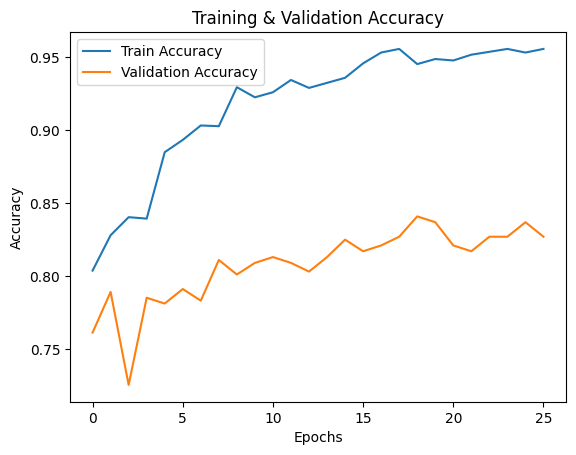

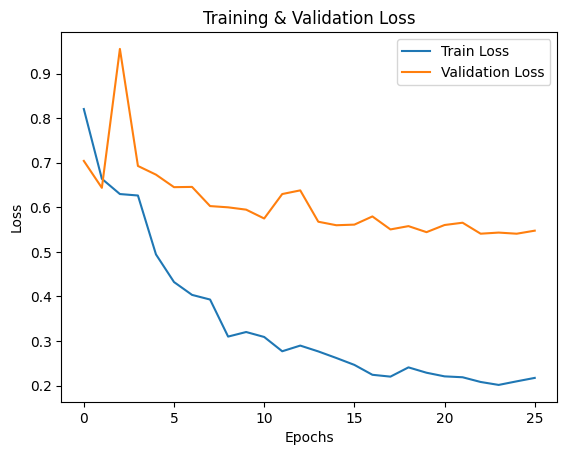

In [59]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


In [61]:
import tensorflow

In [62]:
import sys

# Print Python versio
print("Python version:")
print(sys.version)
print("="*50)

libraries = {
    "tensorflow": "tensorflow",
    "numpy": "numpy",
    "matplotlib": "matplotlib",
    "Pillow": "PIL",  # Pillow is imported as PIL
    "scikit-learn": "sklearn"
}

for lib_name, import_name in libraries.items():
    try:
        module = __import__(import_name)

        if lib_name == "tensorflow":
            print(f"{lib_name} version: {module.__version__}")
            try:
                keras_version = module.keras.__version__
                print(f"tf.keras version: {keras_version}")
            except AttributeError:
                pass
        else:
            print(f"{lib_name} version: {module.__version__}")
    except ImportError:
        print(f"{lib_name} is not installed!")
    print("="*50)


Python version:
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
tensorflow version: 2.17.1
tf.keras version: 3.5.0
numpy version: 1.26.4
matplotlib version: 3.7.5
Pillow version: 11.0.0
scikit-learn version: 1.2.2
